### This notebook does the fine-tuning using roberta, the task is regression

In [1]:
import torch
torch.set_num_threads(20)   # use all logical processors
torch.set_num_interop_threads(8)  # for internal parallelism like BLAS ops

In [2]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    get_scheduler
)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from torch.optim import AdamW

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.auto import tqdm
from pathlib import Path
import numpy as np
import sys
import os
from typing import List, Tuple, Optional

# Custom preprocessor import
sys.path.append(str(Path.cwd().parents[1] / "src"))
from preprocessing.preprocess_dataset import RobertaPreprocessor


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nabin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nabin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Project Setup

In [3]:
PROJECT_ROOT = Path("D:/Conversational-Health-Analytics-")
DATA_DIR = Path("D:/volumes/MACBACKUP/Regression/final_datasets") # Dataset folder
MODEL_DIR = PROJECT_ROOT / "models" / "roberta-v3-regression" # Folder to save model checkpoints
PLOT_DIR = PROJECT_ROOT / "plots" / "roberta-v3-regression" # Folder to save plots

MODEL_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

### Model Config

In [4]:
MODEL_NAME = "roberta-base"
LEARNING_RATE = 5e-6
EPOCHS = 20
BATCH_SIZE = 4
EARLY_STOPPING_PATIENCE = 3

### Dataset Class

In [5]:
class DepressionDataset(Dataset):
    """Custom dataset for regression with RoBERTa."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        # Regression -> float label
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

### Evaluation Function

In [6]:
def evaluate_regression(model, dataloader, device, loss_fn):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

             # Get model outputs (logits)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits.squeeze()
            labels = labels.squeeze()

            # Squeeze the model output and labels to be 1D for the loss function
            # (shape from [batch_size, 1] to [batch_size])
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            all_preds.extend(logits.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)

    return avg_loss, mse, mae

### Plotting Function

In [7]:
def plot_metrics_regression(history, save_dir):
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_dir / 'loss_curve.png')

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['val_mae'], 'g-o', label='Validation MAE')
    plt.title('Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_dir / 'mae_curve.png')

### Device Setup

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU.")

Using CUDA GPU: NVIDIA GeForce RTX 3070 Laptop GPU


### Data Preparation

In [9]:
preprocessor = RobertaPreprocessor(model_name=MODEL_NAME)

print("Loading and preprocessing data...")
X_train_df, y_train_df = preprocessor.load_and_preprocess(DATA_DIR / "final_train_dataset.csv")
X_dev_df, y_dev_df = preprocessor.load_and_preprocess(DATA_DIR / "final_dev_dataset.csv")

# Chunking (Sentence Aware)
X_train_chunked, y_train_chunked = preprocessor.chunk_dataframe(
    X_train_df, y_train_df, strategy="sentence_aware", chunk_size=510, overlap=2
)
X_dev_chunked, y_dev_chunked = preprocessor.chunk_dataframe(
    X_dev_df, y_dev_df, strategy="sentence_aware", chunk_size=510, overlap=2
)

# Tokenization
train_encodings = preprocessor.tokenize(X_train_chunked['text'])
dev_encodings = preprocessor.tokenize(X_dev_chunked['text'])

train_labels = y_train_chunked['label'].tolist()
dev_labels = y_dev_chunked['label'].tolist()

train_dataset = DepressionDataset(train_encodings, train_labels)
dev_dataset = DepressionDataset(dev_encodings, dev_labels)

Token indices sequence length is longer than the specified maximum sequence length for this model (2109 > 512). Running this sequence through the model will result in indexing errors


Loading and preprocessing data...
Successfully loaded D:\volumes\MACBACKUP\Regression\final_datasets\final_train_dataset.csv. Found 107 records.
Text cleaning complete.
Data prepared. X shape: (107, 1), y shape: (107, 1)

Successfully loaded D:\volumes\MACBACKUP\Regression\final_datasets\final_dev_dataset.csv. Found 35 records.
Text cleaning complete.
Data prepared. X shape: (35, 1), y shape: (35, 1)

Starting chunking with strategy: 'sentence_aware'...
Chunking complete. Original docs: 107, Total chunks: 393
Starting chunking with strategy: 'sentence_aware'...
Chunking complete. Original docs: 35, Total chunks: 140
Tokenizing for RoBERTa with max_length=512...
Tokenizing for RoBERTa with max_length=512...


In [10]:
# Suppose train_labels is a list/array of numeric labels
label_counts = np.bincount(np.array(train_labels, dtype=int))  # for integer labels
label_weights = 1.0 / label_counts
sample_weights = [label_weights[int(l)] for l in train_labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

C:\Users\nabin\AppData\Local\Temp\ipykernel_30860\139015559.py:3: RuntimeWarning: divide by zero encountered in divide
  label_weights = 1.0 / label_counts


In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=True)


# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

### Building Regression Model

In [12]:
def build_roberta_regressor(num_labels=1):
    config = AutoConfig.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        problem_type="regression",
        hidden_dropout_prob=0.4,
        attention_probs_dropout_prob=0.5,
    )
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    return model, optimizer

In [13]:
model, optimizer = build_roberta_regressor()
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [14]:
ACCUMULATION_STEPS = 4  # effectively multiplies batch size

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [16]:
# Loss for regression
loss_fn = torch.nn.MSELoss()

In [17]:
# # Scheduler
# num_training_steps = EPOCHS * len(train_loader)
# lr_scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode='min',         # looking for minimum val loss
#     factor=0.5,         # multiply LR by 0.5 when plateau
#     patience=2,         # wait 2 epochs before reducing
#     verbose=True
# )

### Training Loop

In [18]:
history = {'train_loss': [], 'val_loss': [], 'val_mae': []}
best_val_loss = float("inf")
patience_counter = 0
start_time = time.time()

In [19]:
for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    model.train()
    total_train_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True, dynamic_ncols=True)
    optimizer.zero_grad()  # reset gradients at the start of epoch
    
    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / ACCUMULATION_STEPS  # scale down for accumulation
        loss.backward()
        
        if (step + 1) % ACCUMULATION_STEPS == 0 or (step + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()
        
        total_train_loss += loss.item() * ACCUMULATION_STEPS  # scale back for logging
        
        if step % 10 == 0:
            progress_bar.set_postfix(loss=f"{(total_train_loss / (step + 1)):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    
    # --- Validation ---
    model.eval()
    val_loss, val_mse, val_mae = evaluate_regression(model, dev_loader, device, loss_fn)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss (MSE): {val_mse:.4f} | Val MAE: {val_mae:.4f}")

    # Step the scheduler with validation loss
    scheduler.step(val_loss)

    # --- Early stopping ---
    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} -> {val_loss:.4f}. Saving model...")
        best_val_loss = val_loss
        patience_counter = 0
        model.save_pretrained(MODEL_DIR)
        preprocessor.tokenizer.save_pretrained(MODEL_DIR)
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break


--- Epoch 1/20 ---


Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 106.0583 | Val Loss (MSE): 110.0981 | Val MAE: 7.9510
Validation loss improved from inf -> 110.0981. Saving model...

--- Epoch 2/20 ---


Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 91.1001 | Val Loss (MSE): 88.1389 | Val MAE: 6.9369
Validation loss improved from 110.0981 -> 88.1389. Saving model...

--- Epoch 3/20 ---


Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 74.7903 | Val Loss (MSE): 72.1054 | Val MAE: 6.4029
Validation loss improved from 88.1389 -> 72.1054. Saving model...

--- Epoch 4/20 ---


Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 67.6746 | Val Loss (MSE): 62.8048 | Val MAE: 6.1329
Validation loss improved from 72.1054 -> 62.8048. Saving model...

--- Epoch 5/20 ---


Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 56.7666 | Val Loss (MSE): 57.1744 | Val MAE: 6.0536
Validation loss improved from 62.8048 -> 57.1744. Saving model...

--- Epoch 6/20 ---


Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 46.4021 | Val Loss (MSE): 53.7028 | Val MAE: 6.0188
Validation loss improved from 57.1744 -> 53.7028. Saving model...

--- Epoch 7/20 ---


Epoch 7:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 46.0256 | Val Loss (MSE): 51.8427 | Val MAE: 5.9902
Validation loss improved from 53.7028 -> 51.8427. Saving model...

--- Epoch 8/20 ---


Epoch 8:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 52.7532 | Val Loss (MSE): 49.8761 | Val MAE: 5.9824
Validation loss improved from 51.8427 -> 49.8761. Saving model...

--- Epoch 9/20 ---


Epoch 9:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 43.2739 | Val Loss (MSE): 49.0234 | Val MAE: 5.9874
Validation loss improved from 49.8761 -> 49.0234. Saving model...

--- Epoch 10/20 ---


Epoch 10:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 42.3326 | Val Loss (MSE): 48.3680 | Val MAE: 6.0032
Validation loss improved from 49.0234 -> 48.3680. Saving model...

--- Epoch 11/20 ---


Epoch 11:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 39.9577 | Val Loss (MSE): 48.1414 | Val MAE: 6.0159
Validation loss improved from 48.3680 -> 48.1414. Saving model...

--- Epoch 12/20 ---


Epoch 12:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 37.5683 | Val Loss (MSE): 48.1138 | Val MAE: 6.0376
Validation loss improved from 48.1414 -> 48.1138. Saving model...

--- Epoch 13/20 ---


Epoch 13:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 35.7309 | Val Loss (MSE): 48.1070 | Val MAE: 6.0526
Validation loss improved from 48.1138 -> 48.1070. Saving model...

--- Epoch 14/20 ---


Epoch 14:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 37.5471 | Val Loss (MSE): 48.2619 | Val MAE: 6.0716
No improvement for 1 epoch(s).

--- Epoch 15/20 ---


Epoch 15:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 38.2446 | Val Loss (MSE): 48.3914 | Val MAE: 6.0855
No improvement for 2 epoch(s).

--- Epoch 16/20 ---


Epoch 16:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 38.2096 | Val Loss (MSE): 48.3905 | Val MAE: 6.0870
No improvement for 3 epoch(s).
Early stopping triggered.



Training completed in 6.15 minutes.


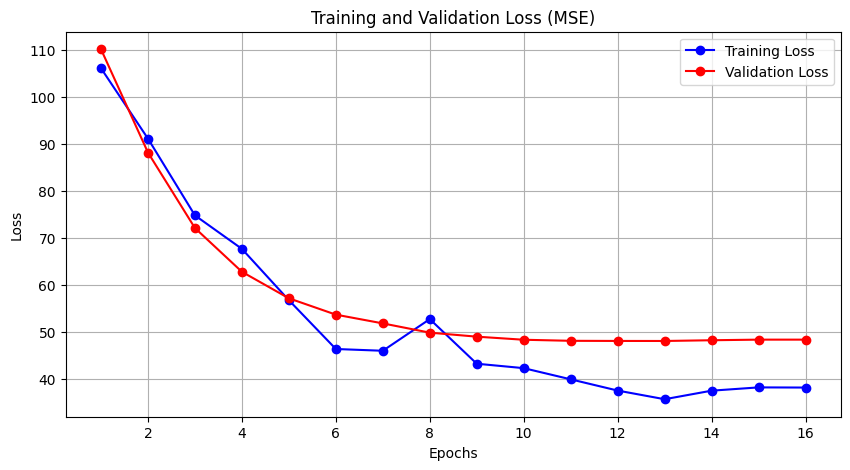

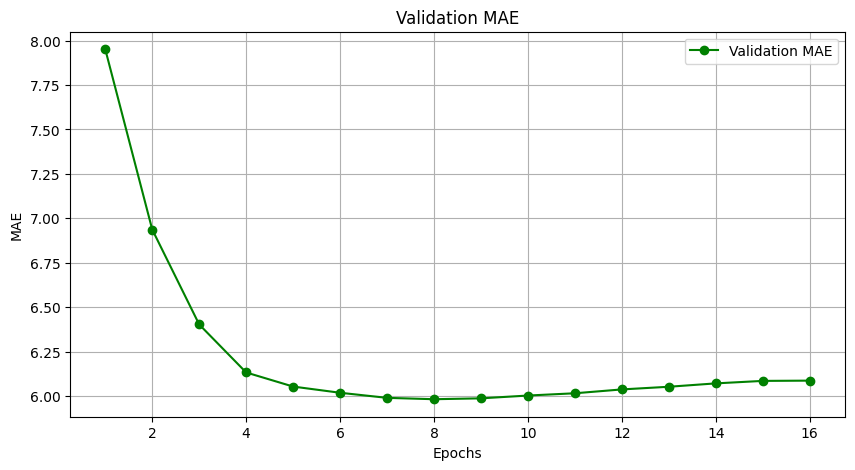

In [20]:
end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes.")
plot_metrics_regression(history, PLOT_DIR)

In [21]:
# model.train()
# for i, batch in enumerate(train_loader):
#     input_ids = batch['input_ids'].to(device)
#     attention_mask = batch['attention_mask'].to(device)
#     labels = batch['labels'].to(device)

#     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#     loss = outputs.loss
#     loss.backward()
#     optimizer.step()
#     torch.cuda.empty_cache()
#     print(f"Batch {i}, loss={loss.item():.4f}")
#     if i == 2:
#         break

In [22]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

CUDA available: True
GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
